## Dirichlet Problem on a Square

We demonstrate here some functionality of the Jupyter environment, SciPy linear algebra tools, and Matplotlib.  We wil construct finite difference solutions to the Dirichlet problem on the domain $[0,1]\times[0,1]$.

\begin{eqnarray}
\Delta u & = & 0 \quad \textrm{in} \hspace{0.25cm} \Omega \\
u & = & g \quad \textrm{on} \hspace{0.25cm}  \partial\Omega
\end{eqnarray}

Objectives of the notebook:

- Demonstrate the use of the module $\texttt{dirchletproblem}$.
- Plot solutions and errors.
- Show the convergence of a set of solutions on various grids
- Compare times for solutions with different SciPy solvers.

The module $\texttt{dirchletproblem}$ contains a single solver called $\texttt{dirichlet_solver}$ that can be used to produce the finite difference solutions.  The solver requires a configuration file that specifies problem data and parameters of the solution such as the grid size and the linear solver that is to be used.  Details of the configuration are in the module documentation and are explained further in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dirichletproblem import dirichlet_solver
import configparser, time, pickle  ## Modules to build the config file, time the runs, and store solution data

### Example 1:  Dirichlet solver for quadratic function

We demonstrate the use of the solver first for a problem with known solution.  We take the quadratic function $u(x,y) = y^2-x^2$ as the solution and specify the boundary values accordingly.

In [3]:
## Set problem parameters and boundary data

## N is number of grid points in each dimension.  Currently must be the same in each dimension.
N = 40

## Solver specifies the linear algebra routine used for solving the linear system.
## Options are 'cg' for conjugate gradient using SciPy's sparse.linalg.cs or 'lu' for dense factorization.
## Tolerance can be configured for cg solver
solver = 'lu'
tol = 1e-06

## Define the boundaries of the domain.
xlower = 0
xupper = 1
ylower = 0
yupper = 1

## Define the boundary conditions.  These variables are set to strings that represent expressions to be
## evaluated along the boundaries (xlower, xupper, ylower, yupper).  (g in the problem statement)
## The value for bc_all will be used for all boundaries if specified.  This way of setting the boundary 
## conditions is useful in the case where we test the code using a known solution to the problem.

#bc_all = 'np.exp(2*np.pi*x)*np.cos(2*np.pi*y)'
bc_all = 'y**2-x**2'
bc_xlower = 'np.sin(2*np.pi*y)'
bc_xupper = '-np.sin(2*np.pi*y)'
bc_ylower = '0'
bc_yupper = '0' 

## Laplacian of the solution.  (f in the problem statement)
laplacian = '0'

## Create config file for solver
## Note that the ConfigParser in this notebook is simply editing a text file that contains the problem data.
## This text file can be modified with any editor in between cell executions to get the same results.

config = configparser.ConfigParser()
config['DIRICHLET DATA'] = {}

if bc_all:
    config['DIRICHLET DATA']['bc_all'] = bc_all
else:
    config['DIRICHLET DATA']['bc_xlower'] = bc_xlower
    config['DIRICHLET DATA']['bc_xupper'] = bc_xupper
    config['DIRICHLET DATA']['bc_ylower'] = bc_ylower
    config['DIRICHLET DATA']['bc_yupper'] = bc_yupper

config['DIRICHLET DATA']['laplacian']= laplacian

config['DIRICHLET DATA']['xlower'] = str(xlower)
config['DIRICHLET DATA']['xupper'] = str(xupper)
config['DIRICHLET DATA']['ylower'] = str(ylower)
config['DIRICHLET DATA']['yupper'] = str(yupper)

config['FD SOLUTION'] = {}
config['FD SOLUTION']['N'] = str(N)
config['FD SOLUTION']['solver'] = solver
config['FD SOLUTION']['tolerance'] = str(tol)

with open('dirichlet.cnf','w') as configfile:
    config.write(configfile)

In [4]:
## Call the solver.  The finite difference solution is returned as an NxN array.
U = dirichlet_solver('dirichlet.cnf')

Solution using lu complete.  Grid: 40 x 40


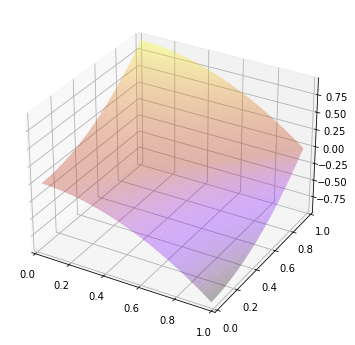

In [5]:
## Construct a scatter or surface plot for visualization.

h = 1.0/(N+1)
x = np.linspace(xlower+h,xupper-h,N)
y = np.linspace(ylower+h,yupper-h,N)
xx, yy = np.meshgrid(x,y)

fig = plt.figure()    
ax = fig.add_subplot(111,projection='3d')
#ax.scatter(xx, yy, U,s=5,cmap='gnuplot',alpha=0.5)
ax.plot_surface(xx, yy, U,cmap='gnuplot',alpha=0.3)

ax.set_xlim(0,1);
ax.set_ylim(0,1);

fig.set_figwidth(8)
fig.set_figheight(6)

In this example, where we know the exact solution, we could compute the exact error in the finite difference solution.  For the quadratic funcion in this example, the local truncation error is zero.  If we use a direct solver, we observe that the solution error is on the order of machine precision.

Max norm of error is 6.661338147750939e-16


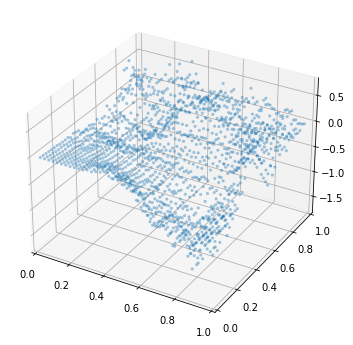

In [6]:
## Define the true solution on the grid

u = yy**2-xx**2
error = u - U
print("Max norm of error is",abs(np.amax(error)))

fig = plt.figure()    
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xx, yy, error,s=5,cmap='gnuplot',alpha=0.3)

ax.set_xlim(0,1);
ax.set_ylim(0,1);

fig.set_figwidth(8)
fig.set_figheight(6)

If instead we use an iterative solver, we see the error in the solution is a function of the specified tolerance.

In [8]:
tol = 1e-05
config['FD SOLUTION']['solver'] = 'cg'
config['FD SOLUTION']['tolerance'] = str(tol)
with open('dirichlet.cnf','w') as configfile:
    config.write(configfile)
    
U = dirichlet_solver('dirichlet.cnf')
error = u - U
print("Max norm of error is",abs(np.amax(error)), " Tolerance:",tol)

tol = 1e-08
config['FD SOLUTION']['tolerance'] = str(tol)
with open('dirichlet.cnf','w') as configfile:
    config.write(configfile)

U = dirichlet_solver('dirichlet.cnf')
error = u - U
print("Max norm of error is",abs(np.amax(error)), " Tolerance:",tol)

Solution using cg complete.  Grid: 40 x 40
Max norm of error is 7.487904242833854e-06  Tolerance: 1e-05
Solution using cg complete.  Grid: 40 x 40
Max norm of error is 6.1581900412388535e-09  Tolerance: 1e-08


### Example 2:  Demonstration of convergence

In this example we set the boundary conditions to produce the harmonic function $u(x,y) = e^{2\pi x}\cos(2\pi y)$.  In this case we know the solution to the problem and can observe the convergence of the finite difference solution as the grid size increases.

Solution using cg complete.  Grid: 40 x 40


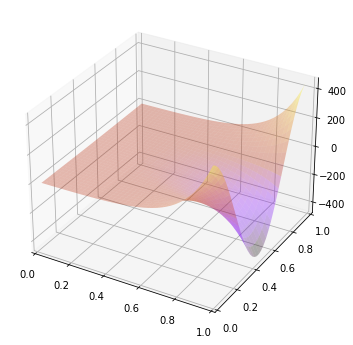

In [10]:
config['DIRICHLET DATA']['bc_all'] = 'np.exp(2*np.pi*x)*np.cos(2*np.pi*y)'
config['FD SOLUTION']['tolerance'] = str(1e-12)
with open('dirichlet.cnf','w') as configfile:
    config.write(configfile)

U = dirichlet_solver('dirichlet.cnf')

h = 1.0/(N+1)
x = np.linspace(xlower+h,xupper-h,N)
y = np.linspace(ylower+h,yupper-h,N)
xx, yy = np.meshgrid(x,y)

fig = plt.figure()    
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(xx, yy, U,cmap='gnuplot',alpha=0.3)

ax.set_xlim(0,1);
ax.set_ylim(0,1);

fig.set_figwidth(8)
fig.set_figheight(6)

We can also graph the exact error to observe that it is large in regions of the domain where the solution is large.

Max norm of error is 0.4408911004591971
Max norm of solution is 454.02310702824167


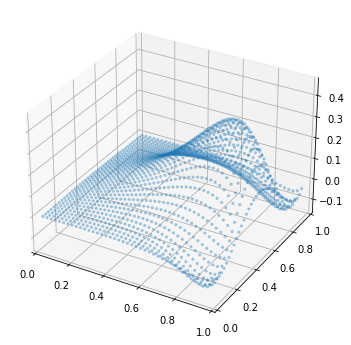

In [11]:
## Define the true solution on the grid

u = np.exp(2*np.pi*xx)*np.cos(2*np.pi*yy)
error = u - U
print("Max norm of error is",abs(np.amax(error)))
print("Max norm of solution is",abs(np.amax(u)))

fig = plt.figure()    
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xx, yy, error,s=5,cmap='gnuplot',alpha=0.3)

ax.set_xlim(0,1);
ax.set_ylim(0,1);

fig.set_figwidth(8)
fig.set_figheight(6)

In [12]:
grids = [20*i for i in range(1,9)]
errors = []
for N in grids:
    config['FD SOLUTION']['N'] = str(N)
    with open('dirichlet.cnf','w') as configfile:
        config.write(configfile)

    U = dirichlet_solver('dirichlet.cnf')
    h = 1.0/(N+1)
    
    x = np.linspace(xlower+h,xupper-h,N)
    y = np.linspace(ylower+h,yupper-h,N)
    xx, yy = np.meshgrid(x,y)
    
    u = np.exp(2*np.pi*xx)*np.cos(2*np.pi*yy)
    error = u - U
    errors.append(abs(np.amax(error)))
    print("Max norm of error is",abs(np.amax(error)),"for",N,"x",N,"grid.")
    
with open('max_errors.pkl','wb') as f:
    pickle.dump([grids,errors],f)

Solution using cg complete.  Grid: 20 x 20
Max norm of error is 1.6621489849240163 for 20 x 20 grid.
Solution using cg complete.  Grid: 40 x 40
Max norm of error is 0.4408911004591971 for 40 x 40 grid.
Solution using cg complete.  Grid: 60 x 60
Max norm of error is 0.19977630642247846 for 60 x 60 grid.
Solution using cg complete.  Grid: 80 x 80
Max norm of error is 0.11333068565139115 for 80 x 80 grid.
Solution using cg complete.  Grid: 100 x 100
Max norm of error is 0.07295273331922658 for 100 x 100 grid.
Solution using cg complete.  Grid: 120 x 120
Max norm of error is 0.05083128176511309 for 120 x 120 grid.
Solution using cg complete.  Grid: 140 x 140
Max norm of error is 0.037442649079565626 for 140 x 140 grid.
Solution using cg complete.  Grid: 160 x 160
Max norm of error is 0.028719767475422486 for 160 x 160 grid.


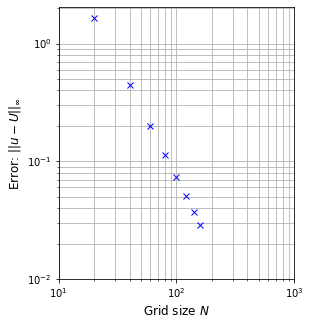

In [13]:
## Plot the errors versus grid size

with open('max_errors.pkl','rb') as f:
    error_data = pickle.load(f)

grids = np.array(error_data[0])
max_errors = np.array(error_data[1])

plt.loglog(grids,max_errors,'bx',label='$||u-U||_{\infty}$')
plt.xlabel('Grid size $N$',fontsize=12)
plt.ylabel('Error: $||u-U||_{\infty}$',fontsize=12)
plt.grid(True,which='both');
plt.xticks([10,100,1000])
plt.yticks([0.01,0.1,1])
ax = plt.gca()
ax.set_aspect('equal')
fig = plt.gcf()
fig.set_figwidth(8);
fig.set_figheight(5);

### Solution time versus grid size

In [65]:
## Run earler config cell to set problem parameters.  This cell will vary N only.
## Data is written to runtimes.pkl
## This cell takes several minutes to run depending on the the range of grids tolerance set.

## Array of grid sizes to run
grids = [40*i for i in range(1,5)]
run_data = [grids]
times = []
solvers = ['cg','lu']

for solver in solvers:
    times = []
    config['FD SOLUTION']['solver'] = solver
    for grid in grids:
        config['FD SOLUTION']['N'] = str(grid)
        with open('runtimes.cnf','w') as configfile:
            config.write(configfile)
        start = time.time()
        U = dirichlet_solver('runtimes.cnf')
        end = time.time()
        times.append(end-start)
    run_data.append(times)

with open('runtimes.pkl','wb') as f:
    pickle.dump(run_data,f)

Solution using cg complete.  Grid: 40 x 40
Solution using cg complete.  Grid: 80 x 80
Solution using cg complete.  Grid: 120 x 120
Solution using cg complete.  Grid: 160 x 160
Solution using lu complete.  Grid: 40 x 40
Solution using lu complete.  Grid: 80 x 80
Solution using lu complete.  Grid: 120 x 120
Solution using lu complete.  Grid: 160 x 160


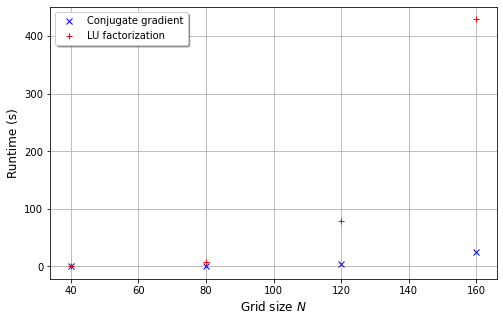

In [75]:
## Plot the runtime versus grid size data

with open('runtimes.pkl','rb') as f:
    run_data = pickle.load(f)

grids = np.array(run_data[0])
cg_times = np.array(run_data[1])
lu_times = np.array(run_data[2])

plt.plot(grids,cg_times,'bx',label='Conjugate gradient')
plt.plot(grids,lu_times,'r+',label='LU factorization')
plt.xlabel('Grid size $N$',fontsize=12)
plt.ylabel('Runtime (s)',fontsize=12)
plt.grid(True);
plt.legend(shadow=True);
fig = plt.gcf()
fig.set_figwidth(8);
fig.set_figheight(5);